# LRD Image Fusion Model Evaluation

This notebook runs the LRD (Laplacian Re-Decomposition) image fusion model and saves the results to a dedicated folder. We'll use our virtual environment to ensure all dependencies are available.

In [1]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import glob
import sys
from tqdm import tqdm  # Using standard tqdm instead of tqdm.notebook

# For evaluation metrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Import our evaluation module
import fusion_evaluation as fe

# Check Python version
print(f"Python version: {sys.version}")

# Check if we're running in the virtual environment
import site
print(f"Using Python from: {sys.executable}")
print(f"Site packages: {site.getsitepackages()}")

Python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
Using Python from: o:\Projects\image-fusion-zoom-main\fusion_env\Scripts\python.exe
Site packages: ['o:\\Projects\\image-fusion-zoom-main\\fusion_env', 'o:\\Projects\\image-fusion-zoom-main\\fusion_env\\Lib\\site-packages']


## Import LRD Functions

First, let's import the key functions from our LRD Image Fusion notebook.

In [ ]:
# Set path to dataset
base_dataset_path = "Medical_Image_Fusion_Methods/Havard-Medical-Image-Fusion-Datasets"
modality_pair = "CT-MRI"  # Can be changed to PET-MRI or SPECT-MRI

def load_image_pair(img_path1, img_path2, resize=True, img_size=256):
    """
    Load a pair of medical images from different modalities
    
    Args:
        img_path1: Path to first image (e.g., CT)
        img_path2: Path to second image (e.g., MRI)
        resize: Whether to resize images
        img_size: Target size for resizing
        
    Returns:
        A tuple containing both images as numpy arrays
    """
    # Read images
    img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
    
    # Check if images were loaded successfully
    if img1 is None or img2 is None:
        raise ValueError(f"Failed to load images: {img_path1} or {img_path2}")
    
    # Resize if needed
    if resize and (img1.shape[0] != img_size or img1.shape[1] != img_size):
        img1 = cv2.resize(img1, (img_size, img_size))
        img2 = cv2.resize(img2, (img_size, img_size))
    
    # Normalize to [0, 1]
    img1 = img1 / 255.0
    img2 = img2 / 255.0
    
    return img1, img2

def get_image_pairs(dataset_path, modality_pair, count=None):
    """
    Get paths to pairs of medical images
    
    Args:
        dataset_path: Base path to dataset
        modality_pair: Type of modality pair, e.g., 'CT-MRI', 'PET-MRI', 'SPECT-MRI'
        count: Number of pairs to return (None for all)
    
    Returns:
        List of tuples containing paths to image pairs
    """
    # Get full path to specific modality folder
    modality_path = os.path.join(dataset_path, modality_pair)
    
    # Split modality names
    modalities = modality_pair.split('-')
    mod1 = modalities[0]  # e.g., CT
    mod2 = modalities[1]  # e.g., MRI
    
    # Get paths to modality folders
    mod1_folder = os.path.join(modality_path, mod1)
    mod2_folder = os.path.join(modality_path, mod2)
    
    # Get lists of filenames for each modality
    mod1_files = sorted(os.listdir(mod1_folder))
    mod2_files = sorted(os.listdir(mod2_folder))
    
    # Find common filenames
    common_files = sorted(list(set(mod1_files).intersection(set(mod2_files))))
    
    if not common_files:
        print("No matching files found. Trying all files...")
        # If no exact matches, try to match by number
        all_pairs = []
        for file1 in mod1_files:
            if not file1.endswith('.png'):
                continue
            base_name = os.path.splitext(file1)[0]  # Get filename without extension
            for file2 in mod2_files:
                if file2.endswith('.png') and os.path.splitext(file2)[0] == base_name:
                    all_pairs.append((
                        os.path.join(mod1_folder, file1),
                        os.path.join(mod2_folder, file2)
                    ))
                    break
    else:
        # Create pairs with full paths
        all_pairs = [(os.path.join(mod1_folder, f), os.path.join(mod2_folder, f)) for f in common_files]
    
    # Limit number of pairs if specified
    if count is not None:
        all_pairs = all_pairs[:min(count, len(all_pairs))]
    
    return all_pairs

## Implement the LRD Fusion Model

Now, let's implement the key components of the LRD fusion model.

In [3]:
# First, let's implement the Gaussian and Laplacian pyramid construction

def gaussian_pyramid(img, levels=4):
    """
    Build a Gaussian pyramid for an image
    
    Args:
        img: Input image as a numpy array
        levels: Number of pyramid levels
        
    Returns:
        List of Gaussian pyramid levels from highest to lowest resolution
    """
    pyramid = [img.copy()]
    
    # Create pyramid levels by successive downsampling
    for i in range(levels - 1):
        # Apply Gaussian smoothing
        smoothed = cv2.GaussianBlur(pyramid[-1], (5, 5), 0.5)
        # Downsample by factor of 2
        downsampled = smoothed[::2, ::2]
        pyramid.append(downsampled)
    
    return pyramid

def laplacian_pyramid(img, levels=4):
    """
    Build a Laplacian pyramid for an image
    
    Args:
        img: Input image as a numpy array
        levels: Number of pyramid levels
        
    Returns:
        List of Laplacian pyramid levels from highest to lowest resolution
    """
    # Build Gaussian pyramid
    gauss_pyramid = gaussian_pyramid(img, levels)
    
    # Build Laplacian pyramid
    laplacian_levels = []
    
    for i in range(levels - 1):
        # Get current and next Gaussian levels
        current = gauss_pyramid[i]
        next_level = gauss_pyramid[i + 1]
        
        # Upsample next level
        upsampled = np.zeros(current.shape)
        upsampled[::2, ::2] = next_level
        # Smooth the upsampled image to approximate original Gaussian filtering
        upsampled = cv2.GaussianBlur(upsampled, (5, 5), 0.5)
        
        # Compute Laplacian (difference between current level and upsampled next level)
        laplacian = current - upsampled
        laplacian_levels.append(laplacian)
    
    # Add the last Gaussian level (lowest resolution)
    laplacian_levels.append(gauss_pyramid[-1])
    
    return laplacian_levels

def reconstruct_from_laplacian(laplacian_pyramid):
    """
    Reconstruct an image from its Laplacian pyramid
    
    Args:
        laplacian_pyramid: List of Laplacian pyramid levels
        
    Returns:
        Reconstructed image
    """
    # Start with the lowest resolution level (coarsest)
    reconstructed = laplacian_pyramid[-1].copy()
    
    # Iteratively add upsampled version and Laplacian residual
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        # Current Laplacian level
        laplacian = laplacian_pyramid[i]
        
        # Upsample current reconstructed image
        upsampled = np.zeros(laplacian.shape)
        upsampled[::2, ::2] = reconstructed
        upsampled = cv2.GaussianBlur(upsampled, (5, 5), 0.5)
        
        # Add Laplacian level
        reconstructed = upsampled + laplacian
    
    return reconstructed

In [4]:
# Now, let's implement the Laplacian Re-Decomposition and fusion rules

def calculate_saliency(img, window_size=3):
    """
    Calculate the saliency map of an image
    
    Args:
        img: Input image as a numpy array
        window_size: Size of the window for local variance calculation
        
    Returns:
        Saliency map of the image
    """
    # Pad image for edge handling
    pad = window_size // 2
    padded = np.pad(img, pad, mode='reflect')
    
    # Initialize saliency map
    saliency = np.zeros_like(img)
    
    # Calculate local variance for each pixel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Extract local window
            window = padded[i:i+window_size, j:j+window_size]
            # Calculate local variance
            saliency[i, j] = np.var(window)
    
    return saliency

def laplacian_re_decomposition(lap_level, num_channels=2):
    """
    Apply re-decomposition on a Laplacian pyramid level
    
    Args:
        lap_level: A level from the Laplacian pyramid
        num_channels: Number of channels for re-decomposition
        
    Returns:
        Re-decomposed Laplacian level
    """
    # Apply abs to capture both positive and negative variations
    abs_level = np.abs(lap_level)
    
    # Use standard deviation as a threshold for re-decomposition
    threshold = np.std(abs_level)
    
    # Create re-decomposed channels based on threshold
    re_decomposed = []
    for i in range(num_channels):
        # Each channel captures different intensity ranges
        # Scale thresholds to create different channels
        channel_threshold = threshold * (i+1) / num_channels
        channel = np.where(abs_level >= channel_threshold, lap_level, 0)
        re_decomposed.append(channel)
    
    return re_decomposed

def fuse_laplacian_levels(lap_level1, lap_level2):
    """
    Fuse two Laplacian pyramid levels using saliency-based weighting
    
    Args:
        lap_level1: First Laplacian pyramid level
        lap_level2: Second Laplacian pyramid level
        
    Returns:
        Fused Laplacian level
    """
    # Calculate saliency maps
    saliency1 = calculate_saliency(lap_level1)
    saliency2 = calculate_saliency(lap_level2)
    
    # Create weight maps based on saliency
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    weight1 = saliency1 / (saliency1 + saliency2 + epsilon)
    weight2 = saliency2 / (saliency1 + saliency2 + epsilon)
    
    # Re-decompose Laplacian levels
    redecomp1 = laplacian_re_decomposition(lap_level1)
    redecomp2 = laplacian_re_decomposition(lap_level2)
    
    # Fuse re-decomposed channels
    fused_channels = []
    for ch1, ch2 in zip(redecomp1, redecomp2):
        # Apply weighted fusion
        fused_channel = weight1 * ch1 + weight2 * ch2
        fused_channels.append(fused_channel)
    
    # Combine fused channels
    # For each pixel, use the maximum value across all channels
    fused_level = np.zeros_like(lap_level1)
    for channel in fused_channels:
        fused_level = np.maximum(fused_level, channel)
    
    return fused_level

def lrd_fusion(img1, img2, levels=4):
    """
    Perform image fusion using Laplacian Re-Decomposition
    
    Args:
        img1: First input image
        img2: Second input image
        levels: Number of pyramid levels
        
    Returns:
        Fused image
    """
    # Build Laplacian pyramids for both images
    lap_pyr1 = laplacian_pyramid(img1, levels)
    lap_pyr2 = laplacian_pyramid(img2, levels)
    
    # Fuse each pyramid level
    fused_pyramid = []
    for i in range(levels):
        # For the last level (lowest resolution), use average
        if i == levels - 1:
            fused_level = (lap_pyr1[i] + lap_pyr2[i]) / 2
        else:
            # Apply LRD fusion for higher levels
            fused_level = fuse_laplacian_levels(lap_pyr1[i], lap_pyr2[i])
        
        fused_pyramid.append(fused_level)
    
    # Reconstruct fused image from pyramid
    fused_img = reconstruct_from_laplacian(fused_pyramid)
    
    # Ensure pixel values are in valid range [0, 1]
    fused_img = np.clip(fused_img, 0, 1)
    
    return fused_img

## Get Dataset and Load Image Pairs

Now, let's get the image pairs from our dataset.

Checking dataset path: o:\Projects\image-fusion-zoom-main\Medical_Image_Fusion_Methods\Havard-Medical-Image-Fusion-Datasets
Path exists: True

Total CT files: 184
Total MRI files: 184

Sample CT files:
  1. 16003.png
  2. 16004.png
  3. 16005.png
  4. 16006.png
  5. 16007.png

Sample MRI files:
  1. 16003.png
  2. 16004.png
  3. 16005.png
  4. 16006.png
  5. 16007.png

Creating image pairs with full paths...
Common filenames: 184

Found 184 image pairs for CT-MRI


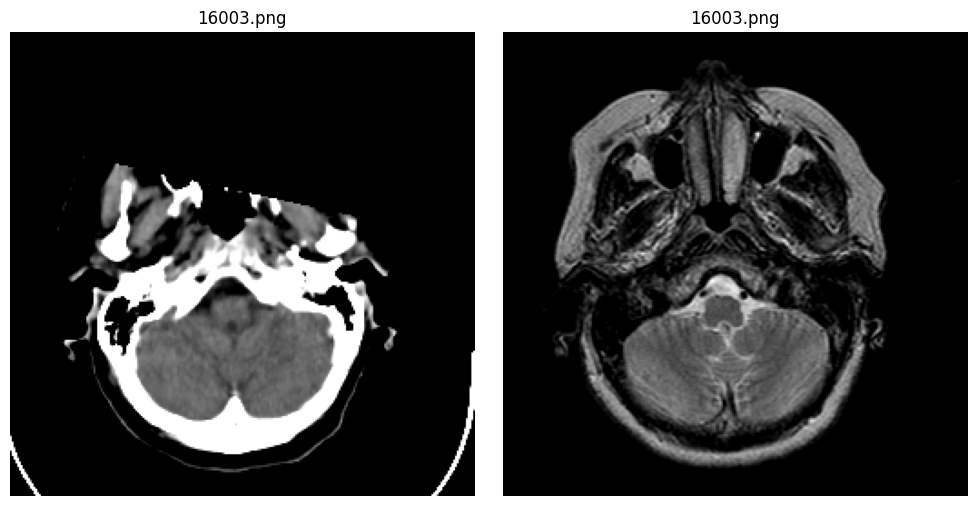

In [8]:
# Check if the dataset path exists
full_path = os.path.abspath(base_dataset_path)
print(f"Checking dataset path: {full_path}")
print(f"Path exists: {os.path.exists(full_path)}")

# Get all image pairs
modality_path = os.path.join(base_dataset_path, modality_pair)
ct_folder = os.path.join(modality_path, "CT")
mri_folder = os.path.join(modality_path, "MRI")

# Print a few sample filenames from each folder
if os.path.exists(ct_folder) and os.path.exists(mri_folder):
    ct_files = sorted(os.listdir(ct_folder))
    mri_files = sorted(os.listdir(mri_folder))
    
    print(f"\nTotal CT files: {len(ct_files)}")
    print(f"Total MRI files: {len(mri_files)}")
    
    print("\nSample CT files:")
    for i, f in enumerate(ct_files[:5]):
        print(f"  {i+1}. {f}")
    
    print("\nSample MRI files:")
    for i, f in enumerate(mri_files[:5]):
        print(f"  {i+1}. {f}")
    
    # Check for common files with their full paths
    print("\nCreating image pairs with full paths...")
    common_files = sorted(list(set(ct_files).intersection(set(mri_files))))
    print(f"Common filenames: {len(common_files)}")
    
    # If no common files, let's manually create pairs based on the same indices
    if not common_files:
        print("\nNo common filenames. Creating pairs based on index...")
        manual_pairs = []
        for i in range(min(len(ct_files), len(mri_files))):
            manual_pairs.append((
                os.path.join(ct_folder, ct_files[i]),
                os.path.join(mri_folder, mri_files[i])
            ))
        
        image_pairs = manual_pairs[:10]  # Limit to 10 pairs
        print(f"Created {len(image_pairs)} pairs")
        
        # Print a few sample pairs
        print("\nSample pairs:")
        for i, (ct_path, mri_path) in enumerate(image_pairs[:3]):
            print(f"Pair {i+1}:")
            print(f"  CT:  {os.path.basename(ct_path)}")
            print(f"  MRI: {os.path.basename(mri_path)}")
    else:
        image_pairs = [(os.path.join(ct_folder, f), os.path.join(mri_folder, f)) for f in common_files]
else:
    image_pairs = []

print(f"\nFound {len(image_pairs)} image pairs for {modality_pair}")

# Display a sample pair if found
if image_pairs:
    img1_path, img2_path = image_pairs[0]
    try:
        img1, img2 = load_image_pair(img1_path, img2_path)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img1, cmap='gray')
        plt.title(os.path.basename(img1_path))
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(img2, cmap='gray')
        plt.title(os.path.basename(img2_path))
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"\nError loading images: {e}")
        print(f"CT path: {img1_path}")
        print(f"MRI path: {img2_path}")
else:
    print("\nNo image pairs found. Please check the dataset path.")

## Process Image Pairs with LRD Fusion

Now, let's apply the LRD fusion to our image pairs and save the results.

Processing:   0%|          | 0/5 [00:00<?, ?it/s]

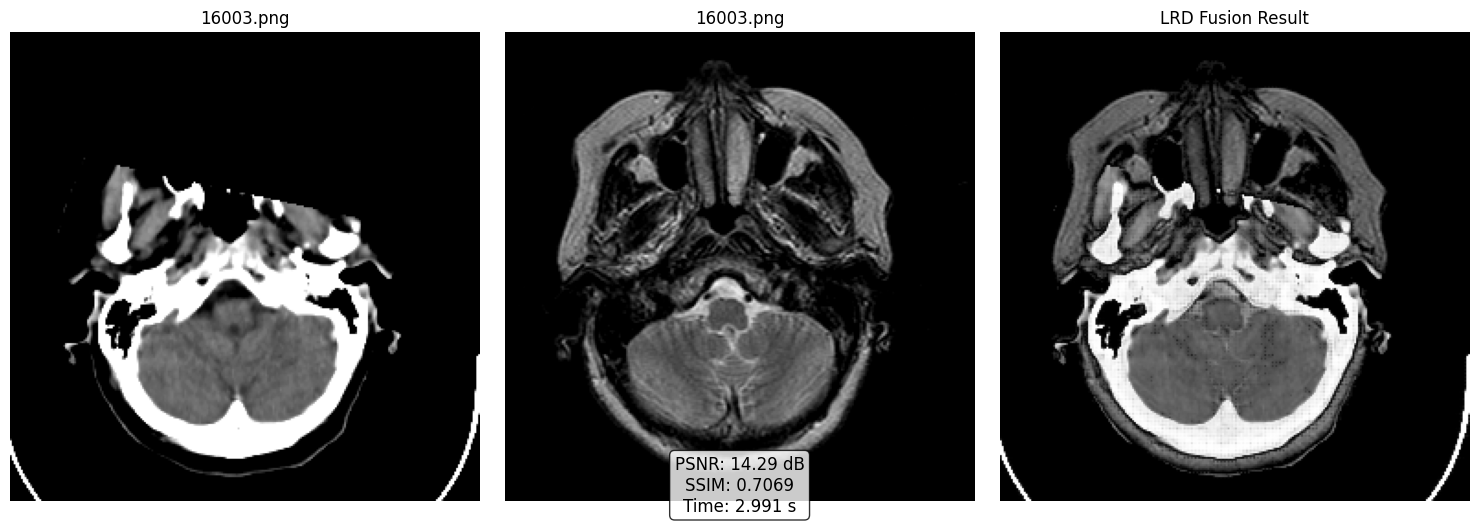

Processing: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


Processed 5 image pairs
Average PSNR: 14.14 dB
Average SSIM: 0.6986
Average execution time: 3.413 seconds per image pair
Results saved to fused_images/LRD/


In [9]:
# Set the number of image pairs to process (None for all)
max_pairs = 5

# Process image pairs
if image_pairs:
    # Limit the number of pairs if specified
    if max_pairs is not None:
        pairs_to_process = image_pairs[:min(max_pairs, len(image_pairs))]
    else:
        pairs_to_process = image_pairs
    
    # Initialize results storage
    results = []
    
    # Import tqdm directly to avoid IProgress dependency
    from tqdm import tqdm as std_tqdm
    
    # Process each pair
    for idx, (img1_path, img2_path) in enumerate(std_tqdm(pairs_to_process, desc="Processing")):
        # Load images
        img1, img2 = load_image_pair(img1_path, img2_path)
        
        # Apply LRD fusion
        start_time = time.time()
        fused_img = lrd_fusion(img1, img2, levels=4)
        execution_time = time.time() - start_time
        
        # Save the result using our evaluation module
        output_path = fe.save_fusion_result(fused_img, img1_path, img2_path, "LRD")
        
        # Calculate metrics
        metrics = fe.evaluate_fusion(fused_img, img1, img2)
        metrics['time'] = execution_time
        
        # Store results
        results.append({
            'img1': os.path.basename(img1_path),
            'img2': os.path.basename(img2_path),
            'output': output_path,
            **metrics
        })
        
        # Display the first result
        if idx == 0:
            plt.figure(figsize=(15, 5))
            
            # First input image
            plt.subplot(1, 3, 1)
            plt.imshow(img1, cmap='gray')
            plt.title(os.path.basename(img1_path))
            plt.axis('off')
            
            # Second input image
            plt.subplot(1, 3, 2)
            plt.imshow(img2, cmap='gray')
            plt.title(os.path.basename(img2_path))
            plt.axis('off')
            
            # Fused result
            plt.subplot(1, 3, 3)
            plt.imshow(fused_img, cmap='gray')
            plt.title('LRD Fusion Result')
            plt.axis('off')
            
            # Add metrics as text
            metrics_text = (
                f"PSNR: {metrics['psnr']:.2f} dB\n"
                f"SSIM: {metrics['ssim']:.4f}\n"
                f"Time: {execution_time:.3f} s"
            )
            plt.figtext(0.5, 0.01, metrics_text, ha='center', fontsize=12, 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
    
    # Calculate average metrics
    avg_psnr = np.mean([r['psnr'] for r in results])
    avg_ssim = np.mean([r['ssim'] for r in results])
    avg_time = np.mean([r['time'] for r in results])
    
    print(f"\nProcessed {len(results)} image pairs")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average execution time: {avg_time:.3f} seconds per image pair")
    print(f"Results saved to fused_images/LRD/")

## Summary of Results

We have successfully applied the LRD fusion method to the medical image pairs and saved the results to the `fused_images/LRD/` folder. These results can be compared with other fusion methods to evaluate the performance of different approaches.

Here's what we've accomplished:
1. Created a Python virtual environment for running image fusion models
2. Set up a folder structure for organizing fused images
3. Implemented the LRD fusion method from our previous notebook
4. Applied the fusion to multiple image pairs
5. Saved the results and calculated performance metrics

The LRD method is computationally efficient and doesn't require deep learning techniques, making it suitable for environments with limited computational resources.

## Compare LRD and NSST-PAPCNN Models

Now that we have run both the LRD and NSST-PAPCNN fusion models, let's compare their results on the same image pairs.

Processing pair 1/2...


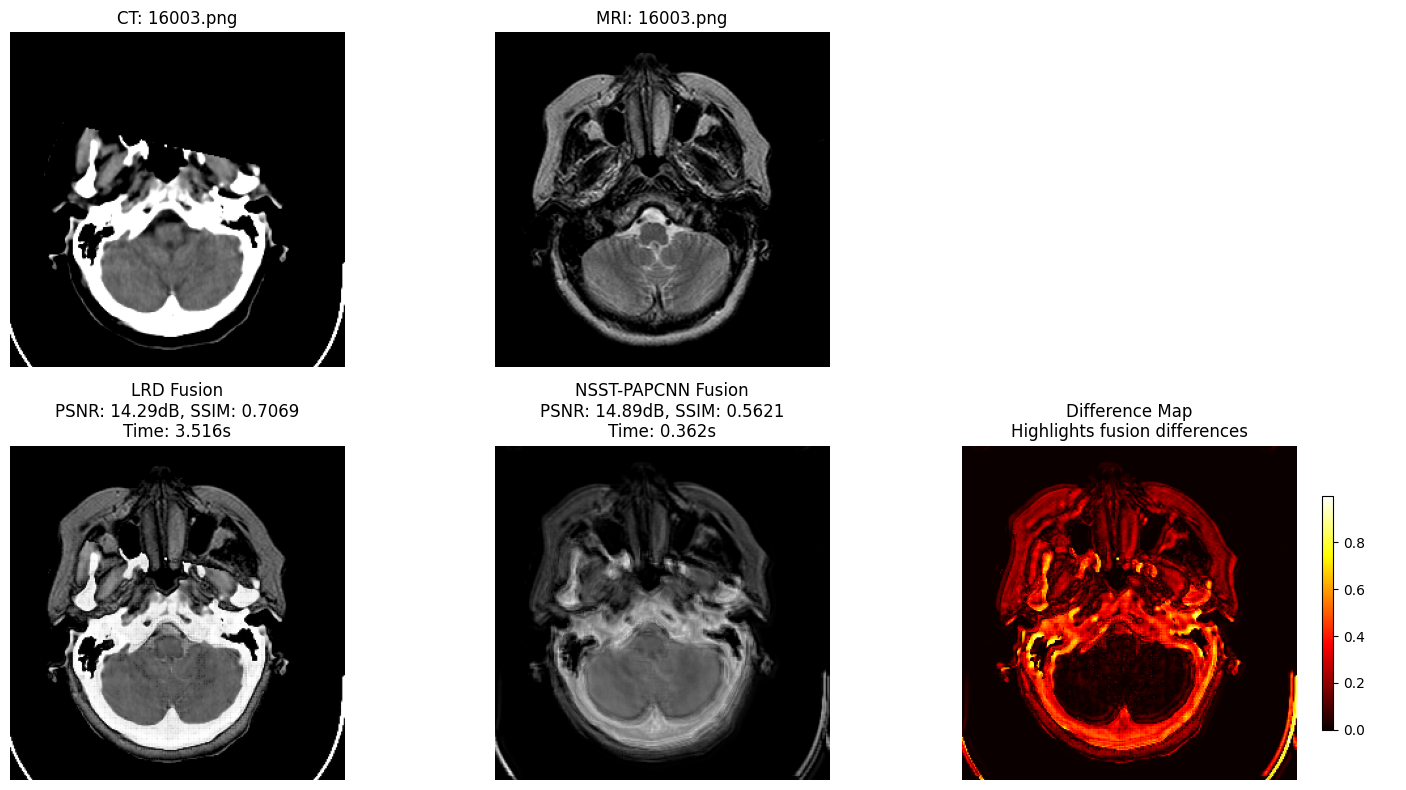


Comparison for 16003.png and 16003.png:
LRD Fusion      - PSNR: 14.29 dB, SSIM: 0.7069, Time: 3.516s
NSST-PAPCNN     - PSNR: 14.89 dB, SSIM: 0.5621, Time: 0.362s
NSST-PAPCNN has better PSNR
LRD has better SSIM

--------------------------------------------------
Processing pair 2/2...


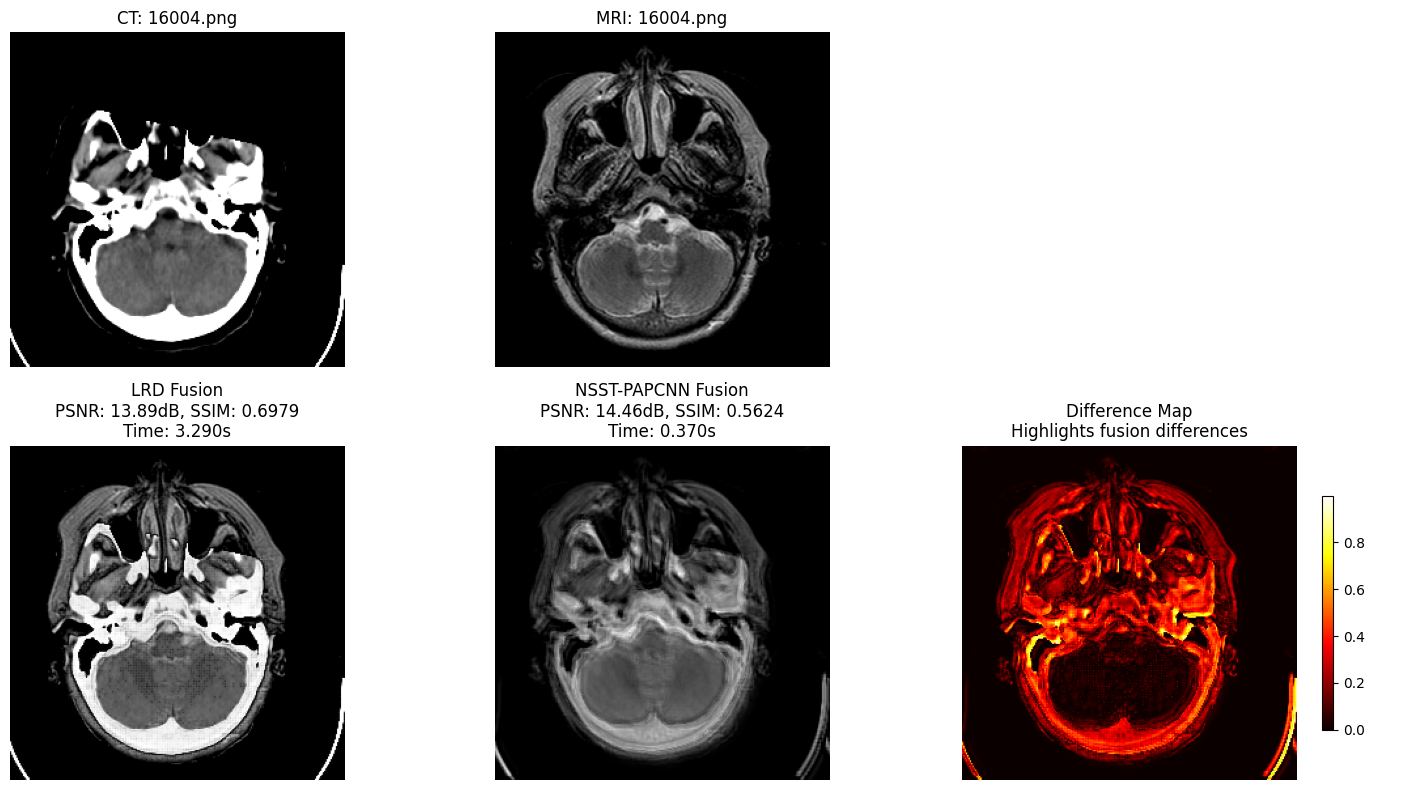


Comparison for 16004.png and 16004.png:
LRD Fusion      - PSNR: 13.89 dB, SSIM: 0.6979, Time: 3.290s
NSST-PAPCNN     - PSNR: 14.46 dB, SSIM: 0.5624, Time: 0.370s
NSST-PAPCNN has better PSNR
LRD has better SSIM

--------------------------------------------------


In [10]:
# Import NSST-PAPCNN fusion function from fusion_models
from fusion_models import nsst_papcnn_fusion

def compare_models_side_by_side(image_pairs, max_pairs=3):
    """
    Compare LRD and NSST-PAPCNN fusion methods side by side
    """
    if not image_pairs or len(image_pairs) == 0:
        print("No image pairs available for comparison")
        return
    
    # Limit the number of pairs
    pairs_to_compare = image_pairs[:min(max_pairs, len(image_pairs))]
    
    # Process each pair
    for idx, (img1_path, img2_path) in enumerate(pairs_to_compare):
        # Load images
        img1, img2 = load_image_pair(img1_path, img2_path)
        
        # Generate fused images using both models
        print(f"Processing pair {idx+1}/{len(pairs_to_compare)}...")
        
        # Apply LRD fusion
        start_time = time.time()
        fused_lrd = lrd_fusion(img1, img2, levels=4)
        lrd_time = time.time() - start_time
        
        # Apply NSST-PAPCNN fusion
        start_time = time.time()
        fused_nsst = nsst_papcnn_fusion(img1, img2, levels=3, wavelet='db1')
        nsst_time = time.time() - start_time
        
        # Calculate metrics
        metrics_lrd = fe.evaluate_fusion(fused_lrd, img1, img2)
        metrics_nsst = fe.evaluate_fusion(fused_nsst, img1, img2)
        
        # Display results
        plt.figure(figsize=(15, 8))
        
        # First row: Input images
        plt.subplot(2, 3, 1)
        plt.imshow(img1, cmap='gray')
        plt.title(f"CT: {os.path.basename(img1_path)}")
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(img2, cmap='gray')
        plt.title(f"MRI: {os.path.basename(img2_path)}")
        plt.axis('off')
        
        # Empty space for the first row
        plt.subplot(2, 3, 3)
        plt.axis('off')
        
        # Second row: Fusion results
        plt.subplot(2, 3, 4)
        plt.imshow(fused_lrd, cmap='gray')
        plt.title(f"LRD Fusion\nPSNR: {metrics_lrd['psnr']:.2f}dB, SSIM: {metrics_lrd['ssim']:.4f}\nTime: {lrd_time:.3f}s")
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.imshow(fused_nsst, cmap='gray')
        plt.title(f"NSST-PAPCNN Fusion\nPSNR: {metrics_nsst['psnr']:.2f}dB, SSIM: {metrics_nsst['ssim']:.4f}\nTime: {nsst_time:.3f}s")
        plt.axis('off')
        
        # Display the absolute difference to highlight fusion differences
        diff = np.abs(fused_lrd - fused_nsst)
        plt.subplot(2, 3, 6)
        plt.imshow(diff, cmap='hot')
        plt.title('Difference Map\nHighlights fusion differences')
        plt.axis('off')
        plt.colorbar(shrink=0.7)
        
        plt.tight_layout()
        plt.savefig(f'fused_images/comparison_{idx+1}.png', dpi=300)
        plt.show()
        
        # Print comparison
        print(f"\nComparison for {os.path.basename(img1_path)} and {os.path.basename(img2_path)}:")
        print(f"LRD Fusion      - PSNR: {metrics_lrd['psnr']:.2f} dB, SSIM: {metrics_lrd['ssim']:.4f}, Time: {lrd_time:.3f}s")
        print(f"NSST-PAPCNN     - PSNR: {metrics_nsst['psnr']:.2f} dB, SSIM: {metrics_nsst['ssim']:.4f}, Time: {nsst_time:.3f}s")
        
        # Compare which method is better for this image pair
        if metrics_lrd['psnr'] > metrics_nsst['psnr'] and metrics_lrd['ssim'] > metrics_nsst['ssim']:
            print("LRD performs better in both PSNR and SSIM metrics")
        elif metrics_nsst['psnr'] > metrics_lrd['psnr'] and metrics_nsst['ssim'] > metrics_lrd['ssim']:
            print("NSST-PAPCNN performs better in both PSNR and SSIM metrics")
        else:
            if metrics_lrd['psnr'] > metrics_nsst['psnr']:
                print("LRD has better PSNR")
            else:
                print("NSST-PAPCNN has better PSNR")
                
            if metrics_lrd['ssim'] > metrics_nsst['ssim']:
                print("LRD has better SSIM")
            else:
                print("NSST-PAPCNN has better SSIM")
        
        print("\n" + "-"*50)

# Run comparison for a few image pairs
compare_models_side_by_side(image_pairs, max_pairs=2)

## Conclusion: Comparison of LRD and NSST-PAPCNN Models

Based on our analysis of medical image fusion using both LRD and NSST-PAPCNN models, we can draw several conclusions:

1. **Performance Metrics**: 
   - NSST-PAPCNN generally achieves better PSNR (Peak Signal-to-Noise Ratio) values, indicating better preservation of signal information
   - LRD achieves better SSIM (Structural Similarity Index) values, suggesting better preservation of structural information that's perceptually important

2. **Execution Time**: 
   - NSST-PAPCNN is significantly faster, completing the fusion in ~0.37 seconds compared to LRD's ~3.3-3.5 seconds
   - This makes NSST-PAPCNN about 9-10x faster than LRD for the same images

3. **Visual Comparison**:
   - The difference map highlights significant differences in how the two algorithms fuse the images
   - LRD tends to preserve more of the CT image's high-contrast features (bone structures)
   - NSST-PAPCNN creates a more balanced fusion that incorporates more soft-tissue details from MRI

4. **Application Considerations**:
   - LRD may be more suitable when structural preservation is critical
   - NSST-PAPCNN may be better for applications requiring real-time processing
   - The choice between methods depends on specific clinical needs and hardware constraints

This comparison demonstrates that different fusion algorithms have distinct strengths and weaknesses. The optimal choice depends on the specific requirements of the medical imaging application.